In [1]:
import numpy as np
import cv2 as cv
import  matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
img1 = cv.imread('data/FurukawaPonce/MorpheusL.jpg') #queryimage # left image
img2 = cv.imread('data/FurukawaPonce/MorpheusR.jpg') #trainimage # right image

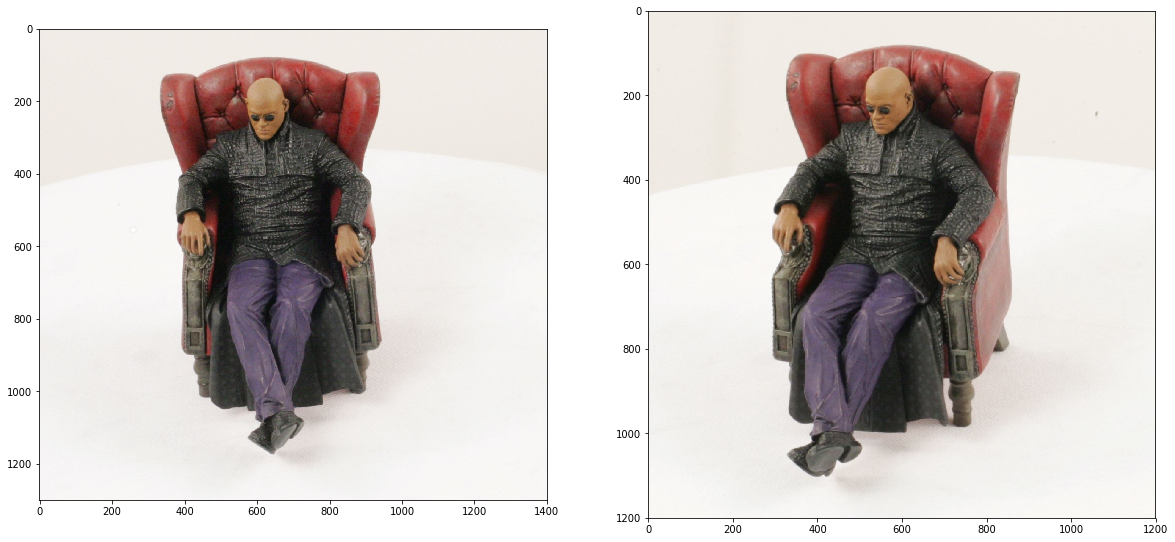

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(121),plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.subplot(122),plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.show()

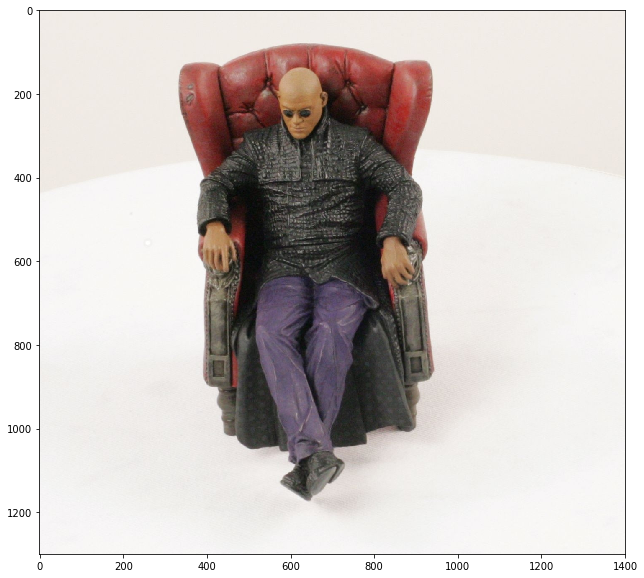

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))


plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB));



### Fórmula de triangulação

distancia = altura * distancia focal / altura em pixels na imagem

altura = distancia * altura em pixels na imagem / distancia focal

In [5]:
f = 6704.926882 #pixels

In [6]:
top_couch_distance = 250 # mm
#low_couch_distance = ??? # mm

top_couch_point =  np.array([160,1015])
bottom_couch_point = np.array([600,850])
euclidean_dist = np.linalg.norm(top_couch_point - bottom_couch_point)
print(f'height of the couch in pixels: {euclidean_dist}px')
#euclidean_dist = 400

height of the couch in pixels: 469.9202059924642px


In [7]:
height = top_couch_distance * euclidean_dist / f
print(f'morpheus couch height: {round(height,2)}cm')

morpheus couch height: 17.52cm


## Using matched points

In [8]:
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
len(pts1),len(pts2)

(311, 311)

In [9]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

In [10]:
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

In [11]:
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
len(pts1),len(pts2)

(229, 229)

## Load projection matrices

In [12]:
mtx_1 = [ 
    [4265.08, 5195.24, -565.379, -1.37072e+06],
    [1636.7, -1954.5, -6218.58, 2.75156e+06],
    [-0.645659, 0.624306, -0.439734, 2977.41] ]
mtx_2 = [
    [2567.28, 6197.89, -641.912, -1.26828e+06],
    [1969.58, -1410.57, -6237.08, 2.45107e+06],
    [-0.803929, 0.431864, -0.40889, 3242.75] ]

mtx_1 = np.array(mtx_1)
mtx_2 = np.array(mtx_2)

In [13]:
pts1.shape

(229, 2)

## Triangulate 2d points to get the 3d

### left points

In [14]:
# left line of blue square
pts_chair_left = np.array([[350,135],
                          [425,700]]).astype(float)
pts_chair_left

array([[350., 135.],
       [425., 700.]])

### right points

In [15]:
# left line of blue square
pts_chair_right = np.array([[345,116],
                            [315,650]]).astype(float)
pts_chair_right

array([[345., 116.],
       [315., 650.]])

In [16]:
points_3D = cv.triangulatePoints(mtx_1, mtx_2, pts_chair_left, pts_chair_right)
print(points_3D.shape)
points_3D

(4, 2)


array([[ 0.50236543, -0.67107834],
       [ 0.70281731, -0.66668103],
       [ 0.50365817, -0.32431204],
       [ 0.00228901, -0.00345898]])

In [17]:
point_3D_TOP = points_3D.T[0]
point_3D_BOT = points_3D.T[1]

point_3D_TOP

array([0.50236543, 0.70281731, 0.50365817, 0.00228901])

In [18]:
point_3D_TOP = point_3D_TOP / point_3D_TOP[3]
point_3D_TOP

array([219.4684881 , 307.03994102, 220.03324689,   1.        ])

In [19]:
point_3D_BOT = point_3D_BOT / point_3D_BOT[3]
point_3D_BOT

array([194.01045248, 192.73917765,  93.75943505,   1.        ])

In [20]:
euclidean_dist_3d = np.linalg.norm(point_3D_TOP - point_3D_BOT)
euclidean_dist_3d

172.21455118240144

### calibrate stereo setup (FAIL)

In [21]:
# #vertical_blue
# img_tst = cv.line(img1, (350,135), (425,700), (255,0,0), 5)


# fig, ax = plt.subplots(figsize=(20, 10))



# plt.imshow(cv.cvtColor(img_tst, cv.COLOR_BGR2RGB))
# plt.show()

In [22]:
# fig, ax = plt.subplots(figsize=(20, 10))


# plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB));


# img2 = cv.line(img2, (345,116), (315,650), (255,0,0), 5)


# plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
# plt.show()

## ### ### ### ### ### ### 

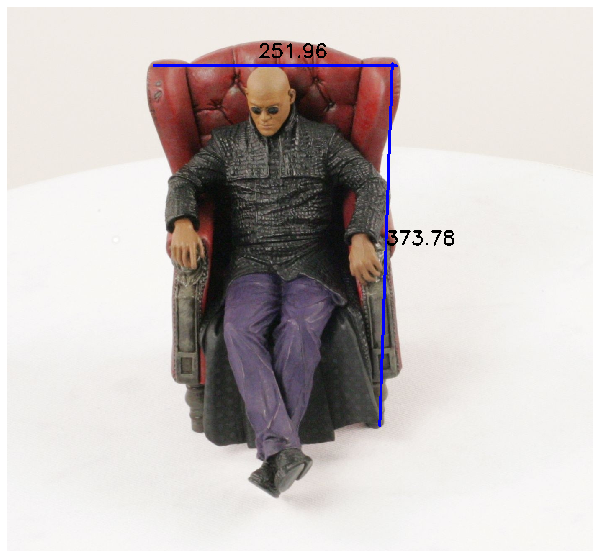

In [47]:
#vertical_blue
img_tst = cv.line(img1, (920,135), (890,1000), (255,0,0), 5)
img_tst = cv.putText(img1, "373.78",(905,567),cv.FONT_HERSHEY_SIMPLEX,1.5, (0,0,0),3)

fig, ax = plt.subplots(figsize=(20, 10))

fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)


plt.axis('off')

plt.imshow(cv.cvtColor(img_tst, cv.COLOR_BGR2RGB))
plt.show()

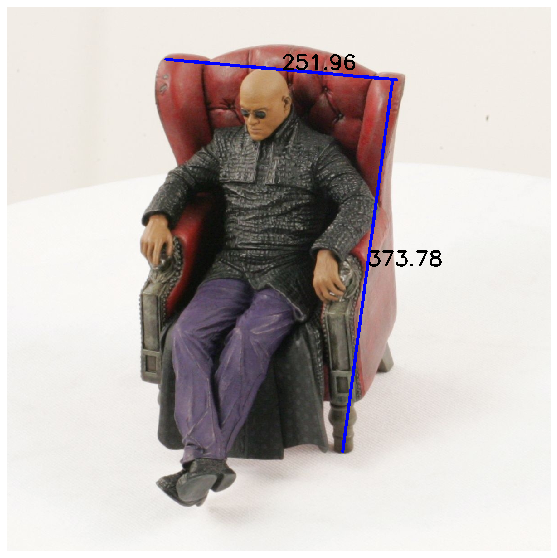

In [48]:
fig, ax = plt.subplots(figsize=(20, 10))


plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB));

fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)


plt.axis('off')


img2 = cv.line(img2, (850,160), (740,980), (255,0,0), 5)
img2 = cv.putText(img2, "373.78",(795,570),cv.FONT_HERSHEY_SIMPLEX,1.5, (0,0,0),3)

plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.show()

In [25]:
# left line of blue square
pts_chair_left = np.array([[920,135]]).astype(float)
pts_chair_left

array([[920., 135.]])

In [26]:
# left line of blue square
pts_chair_right = np.array([[850,160]]).astype(float)
pts_chair_right

array([[850., 160.]])

In [27]:
points_3D = cv.triangulatePoints(mtx_1, mtx_2, pts_chair_left.T, pts_chair_right.T)
print(points_3D.shape)
points_3D

(4, 1)


array([[0.55478692],
       [0.6893576 ],
       [0.46582785],
       [0.00141273]])

In [28]:
point_3D_TOP = points_3D.T[0]
#point_3D_BOT = points_3D.T[1]

point_3D_TOP

array([0.55478692, 0.6893576 , 0.46582785, 0.00141273])

In [29]:
point_3D_TOP = point_3D_TOP / point_3D_TOP[3]
point_3D_TOP

array([392.70475778, 487.96033231, 329.73526781,   1.        ])

In [30]:
# left line of blue square
pts_chair_left = np.array([[890,1000]]).astype(float)
pts_chair_left

array([[ 890., 1000.]])

In [31]:
# left line of blue square
pts_chair_right = np.array([[740,980]]).astype(float)
pts_chair_right

array([[740., 980.]])

In [32]:
points_3D = cv.triangulatePoints(mtx_1, mtx_2, pts_chair_left.T, pts_chair_right.T)
print(points_3D.shape)
points_3D

(4, 1)


array([[-0.79652668],
       [-0.60427492],
       [ 0.01985729],
       [-0.00165696]])

In [33]:
point_3D_BOT = points_3D.T[0]

In [34]:
point_3D_BOT = point_3D_BOT / point_3D_BOT[3]
point_3D_BOT

array([480.71465581, 364.68811062, -11.98414641,   1.        ])

In [35]:
euclidean_dist_3d = np.linalg.norm(point_3D_TOP - point_3D_BOT)
euclidean_dist_3d

373.7832805883909

### Horizontal measures

In [36]:
img1 = cv.imread('data/FurukawaPonce/MorpheusL.jpg') #queryimage # left image
img2 = cv.imread('data/FurukawaPonce/MorpheusR.jpg') #trainimage # right image

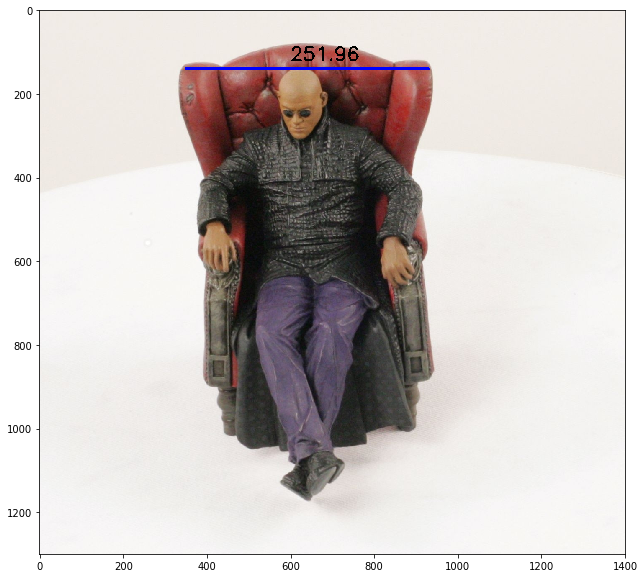

In [37]:
#horizontal_blue
img1 = cv.line(img1, (350,140), (930,140), (255,0,0), 5)
img1 = cv.putText(img1, "251.96",(600,120),cv.FONT_HERSHEY_SIMPLEX,1.5, (0,0,0),3)

fig, ax = plt.subplots(figsize=(20, 10))


plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.show()

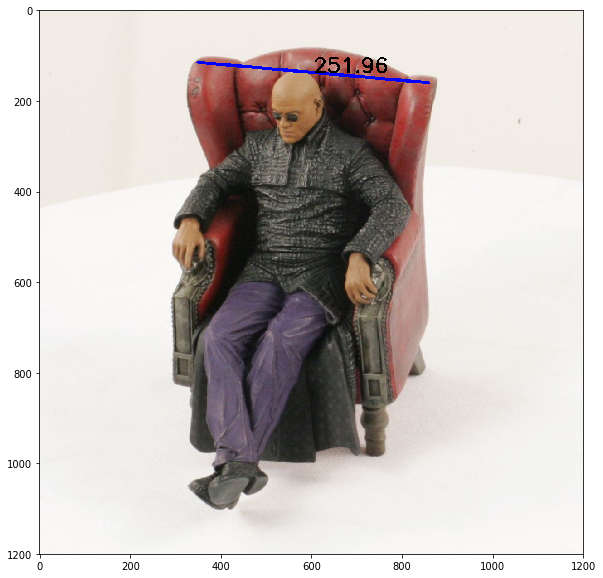

In [38]:
#horizontal_blue
img2 = cv.line(img2, (350,115), (860,160), (255,0,0), 5)
img2 = cv.putText(img2, "251.96",(605,137),cv.FONT_HERSHEY_SIMPLEX,1.5, (0,0,0),3)

fig, ax = plt.subplots(figsize=(20, 10))


plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.show()

In [39]:

# left line of blue square
pts_chair_left = np.array([[350,140], [930,140]]).astype(float)
pts_chair_left

array([[350., 140.],
       [930., 140.]])

In [40]:
# left line of blue square
pts_chair_right = np.array([[350,115],
                            [860,160]]).astype(float)
pts_chair_right

array([[350., 115.],
       [860., 160.]])

In [41]:
points_3D = cv.triangulatePoints(mtx_1, mtx_2, pts_chair_left.T, pts_chair_right.T)
print(points_3D.shape)
points_3D

(4, 2)


array([[0.40078233, 0.55568934],
       [0.65041175, 0.69140451],
       [0.64523963, 0.46170032],
       [0.0019774 , 0.00140646]])

In [42]:
point_3D_TOP = points_3D.T[0]
point_3D_BOT = points_3D.T[1]

In [43]:
point_3D_TOP = point_3D_TOP / point_3D_TOP[3]
point_3D_TOP

array([202.68183314, 328.92330023, 326.30767945,   1.        ])

In [44]:
point_3D_BOT = point_3D_BOT / point_3D_BOT[3]
point_3D_BOT

array([395.09738129, 491.59142018, 328.27080514,   1.        ])

In [45]:
euclidean_dist_3d = np.linalg.norm(point_3D_TOP - point_3D_BOT)
euclidean_dist_3d

251.9692724929614

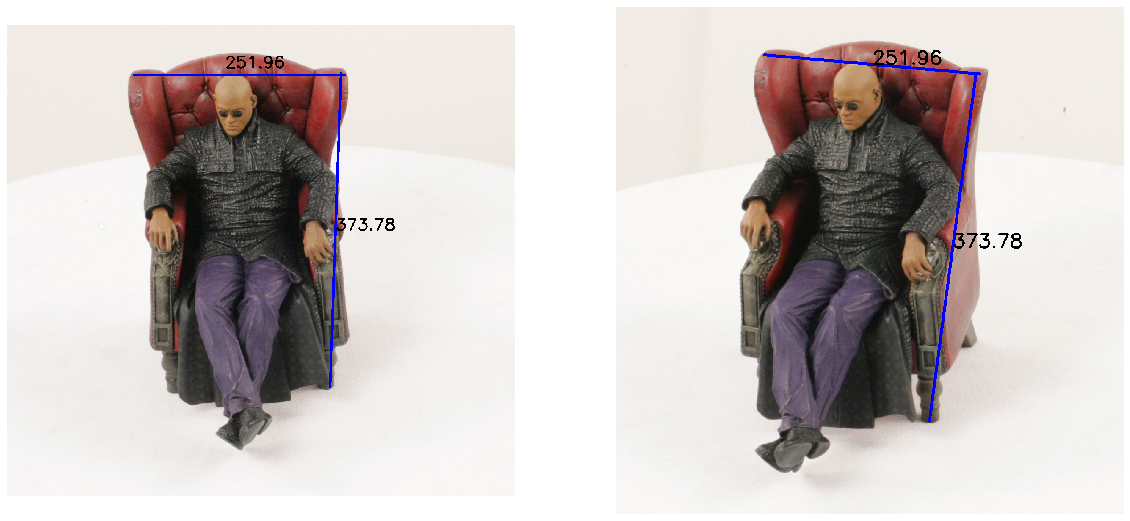

In [49]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.subplot(121),plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.subplot(122),plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))


plt.subplot(121).get_xaxis().set_visible(False)
plt.subplot(121).get_yaxis().set_visible(False)
plt.subplot(122).get_xaxis().set_visible(False)
plt.subplot(122).get_yaxis().set_visible(False)

plt.subplot(121).axis('off')
plt.subplot(122).axis('off')

plt.show()